In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

/ext3/miniconda3/envs/owl_boto/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model

In [2]:
# https://huggingface.co/transformers/v3.2.0/custom_datasets.html

In [2]:
checkpoint = "l3cube-pune/hing-roberta-mixed" #xlm-roberta-base

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

tokenizer_config.json: 100%|██████████| 406/406 [00:00<00:00, 2.20MB/s]
tokenizer.json: 100%|██████████| 17.1M/17.1M [00:00<00:00, 113MB/s]
config.json: 100%|██████████| 756/756 [00:00<00:00, 5.90MB/s]
model.safetensors: 100%|██████████| 1.11G/1.11G [00:20<00:00, 55.0MB/s]
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/hing-roberta-mixed and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Create Datasets

In [2]:
class HSDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [19]:
train_df = pd.read_csv("data/splits/train.csv")
val_df = pd.read_csv("data/splits/val.csv")
test_df = pd.read_csv("data/splits/test.csv")

train_encodings = tokenizer(train_df['tweet_text'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")
val_encodings = tokenizer(val_df['tweet_text'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_df['tweet_text'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

train_dataset = HSDataset(train_encodings, train_df['offense'].tolist())
val_dataset = HSDataset(val_encodings, val_df['offense'].tolist())
test_dataset = HSDataset(test_encodings, test_df['offense'].tolist())

In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

In [21]:
class_instance_counts = torch.tensor(list(dict(Counter(train_df['offense'].tolist())).values()))
class_instance_probs = class_instance_counts/class_instance_counts.sum().item()
class_weights = 1 / class_instance_probs
class_weights.to(device)

tensor([1.4299, 3.3263], device='cuda:0')

In [22]:
class_instance_counts.sum().item()

6809

## Define Trainer

In [14]:
# https://huggingface.co/docs/transformers/main_classes/trainer

class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits.squeeze()
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [15]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_steps=50,
    evaluation_strategy="steps",
    label_names=["labels"]
)

In [10]:
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=50,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
gradient_checkpointing_kwargs=None,
greater_is_better=None,
group_by_length=False,
half_precision_backend=au

In [16]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='binary')
    return {
        'f1': f1,
    }

In [17]:
training_args.evaluation_strategy

<IntervalStrategy.STEPS: 'steps'>

In [23]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    class_weights=class_weights.to(device),
    compute_metrics = compute_metrics
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [14]:
# trainer.compute_metrics = compute_metrics

In [15]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sharad-dargan (a-is-all-we-need). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1
50,0.691600,0.675096,0.375000
100,0.658400,0.600592,0.572438
150,0.610500,0.563876,0.597938
200,0.575300,0.521388,0.639296
250,0.562800,0.493470,0.651601
300,0.535300,0.478929,0.673953
350,0.505100,0.482697,0.690840
400,0.504100,0.579168,0.657971
450,0.504200,0.477465,0.686308
500,0.467100,0.510452,0.685714


TrainOutput(global_step=1278, training_loss=0.41549563743698764, metrics={'train_runtime': 361.0012, 'train_samples_per_second': 56.584, 'train_steps_per_second': 3.54, 'total_flos': 1784525038540200.0, 'train_loss': 0.41549563743698764, 'epoch': 3.0})

In [16]:
trainer.save_model('./results/hingbert_mixed_ft_10k/model')

## Evaluation

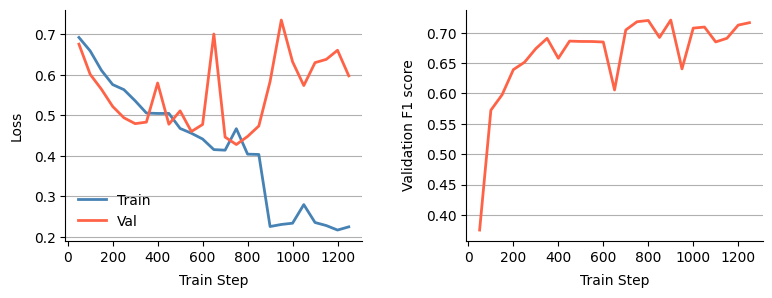

In [17]:
train_loss_df = pd.DataFrame(trainer.state.log_history[0:-1:2])
eval_loss_df = pd.DataFrame(trainer.state.log_history[1::2])

fig, axs = plt.subplots(1,2,figsize=(9,3), gridspec_kw={"wspace":0.35})
axs[0].plot(train_loss_df["step"], train_loss_df["loss"], color='steelblue', lw=2, label="Train")
axs[0].plot(eval_loss_df["step"], eval_loss_df["eval_loss"], color='tomato', lw=2, label="Val")
axs[0].set_xlabel("Train Step", labelpad=7)
axs[0].set_ylabel("Loss", labelpad=7)
axs[0].legend(frameon=False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].grid(axis='y')

axs[1].plot(eval_loss_df["step"], eval_loss_df["eval_f1"], color='tomato', lw=2)
axs[1].set_xlabel("Train Step", labelpad=7)
axs[1].set_ylabel("Validation F1 score", labelpad=7)
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].grid(axis='x')

plt.grid()
plt.show()

In [24]:
test_preds = trainer.predict(test_dataset)
test_preds.metrics

{'test_loss': 0.5677648186683655,
 'test_f1': 0.7269303201506592,
 'test_runtime': 5.0251,
 'test_samples_per_second': 169.349,
 'test_steps_per_second': 10.746}

### Test Results

In [25]:
test_labels = np.argmax(test_preds.predictions, axis=1)

monolingual = test_df[test_df["codemixed"] == 0]
monolingual_gt = monolingual["offense"].values
monolingual_preds = test_labels[monolingual.index]

codemixed = test_df[test_df["codemixed"] == 1]
codemixed_gt = codemixed["offense"].values
codemixed_preds = test_labels[codemixed.index]

results = {}
results["monolingual"] = f1_score(monolingual_gt, monolingual_preds, average='macro')
results["codemixed"] = f1_score(codemixed_gt, codemixed_preds, average='macro')
results["overall"] = f1_score(test_df["offense"].values, test_labels, average='macro')
results

{'monolingual': 0.7992123670134603,
 'codemixed': 0.7964812060372977,
 'overall': 0.8015522651137583}

### Cross-Domain Evaluation

In [13]:
# checkpoint =  #xlm-roberta-base

tokenizer = AutoTokenizer.from_pretrained("l3cube-pune/hing-roberta-mixed")
model = AutoModelForSequenceClassification.from_pretrained("results/hingbert_mixed_ft_10k/model")

In [4]:
new_data_file = "/scratch/sn3250/NLP/cm-hate-speech-detection/data/cm_hate_combined.csv"

In [5]:
new_df = pd.read_csv(new_data_file)

In [6]:
new_df = pd.read_csv(new_data_file)

new_data_encodings = tokenizer(new_df['tweet'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

new_dataset = HSDataset(new_data_encodings, new_df['offense'].tolist())

In [7]:
new_dl = DataLoader(new_dataset, batch_size=8, shuffle=False)

In [8]:
pred_labels = []
for i, inputs in tqdm(enumerate(new_dl)):
    with torch.no_grad():
        output = model(**inputs)
    preds = torch.argmax(output.logits, dim=1)
    pred_labels.append(preds)

81it [03:23,  2.52s/it]


In [9]:
pred_labels_np = np.array(torch.cat(pred_labels))

In [10]:
new_df["pred_label"] = pred_labels_np

In [11]:
gender_gt = new_df[new_df["domain"]=="gender"]["offense"]
gender_preds = new_df[new_df["domain"]=="gender"]["pred_label"]

religion_gt = new_df[new_df["domain"]=="religion"]["offense"]
religion_preds = new_df[new_df["domain"]=="religion"]["pred_label"]

so_gt = new_df[new_df["domain"]=="orientation"]["offense"]
so_preds = new_df[new_df["domain"]=="orientation"]["pred_label"]

In [12]:
results = {}
results["gender"] = f1_score(gender_gt, gender_preds, average='macro')
results["religion"] = f1_score(religion_gt, religion_preds, average='macro')
results["orientation"] = f1_score(so_gt, so_preds, average='macro')
results["overall"] = f1_score(new_df["offense"].values, pred_labels_np, average='macro')
results

{'gender': 0.787767038029062,
 'religion': 0.7158844820014235,
 'orientation': 0.7348772579898101,
 'overall': 0.7515413025194719}